## Fine-tuning Clip on Flickr Image Dataset


The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

![image.png](https://miro.medium.com/max/786/1*tg7akErlMSyCLQxrMtQIYw.png)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 640.0 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jxgvb0ab
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jxgvb0ab
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... - done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=55510c1f768f3cbf6fd9daeb8be874d1edb67daa3e51fae213a8169320bc2bff
  Stored in directory: /tmp/pip-ephem-wheel-cache-hjxhm8zn/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [3]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
print("Torch version:", torch.__version__)

Torch version: 1.11.0


## Load Model & Data

previous translations were generated through a Transformer, see this [link](https://github.com/statscol/clip-fine-tuning)

In [4]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_csv("https://github.com/statscol/clip-fine-tuning/raw/main/data/results.csv",sep="|")
labels.head()

,image_name,comment_number,comment,translations
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,Dos chicos jóvenes con el pelo shaggy mirar a ...
1,10002456.jpg,0,Several men in hard hats are operating a gian...,Varios hombres con sombreros duros están opera...
2,1000268201.jpg,0,A child in a pink dress is climbing up a set ...,Un niño en un vestido rosa es subir un conjunt...
3,1000344755.jpg,0,Someone in a blue shirt and hat is standing o...,Alguien con una camisa azul y sombrero está de...
4,1000366164.jpg,0,"Two men , one in a gray shirt , one in a blac...","Dos hombres, uno en camisa gris, uno en camisa..."


In [5]:
# keep the first caption per image and use only 20% of the data for training
labels=labels[~labels.duplicated(subset="image_name",keep="first")].sample(frac=1)

## Translate Captions from english to spanish 

 small code snippet to show how translations were obtained
```python
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pathlib import Path
import pandas as pd
from transformers import pipeline
from datasets import Dataset as hfd


DEVICE_PIPE=0 if torch.cuda.is_available() else -1
OUT_PATH="/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"


##download translator
pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es",device=DEVICE_PIPE)


def translate_to_spanish(instance):
    instance['translation']=pipe(instance['caption'])
    return instance

##apply to data
captions=[{'caption':i.strip()} for i in labels[' comment'].values.tolist()]
captions = hfd.from_list(captions)
print("Created HF-Dataset with captions\n Starting Translation using batches of size 10")
captions=captions.map(translate_to_spanish,batched=True,batch_size=10)
captions_df=captions.to_pandas()
translations=[i['translation_text'].strip() for i in captions_df.translation.values.tolist()]
labels['translations']=translations

```

In [6]:
torch.cuda.empty_cache()

In [7]:
#preprocess is just a sequential module
model, preprocess = clip.load("RN50x4")

100%|███████████████████████████████████████| 402M/402M [00:06<00:00, 65.8MiB/s]


In [8]:
labels['captions']=labels['translations'].map(lambda d: d.strip())
train,test=train_test_split(labels,train_size=0.7)
##make sure when using ImageFolder, idx positions match, ImageFolder will load files in ascending order by filename
train.sort_values(by="image_name",ascending=True,inplace=True)
test.sort_values(by="image_name",ascending=True,inplace=True)
print(train.shape,test.shape)

(22248, 5) (9535, 5)


### Copy files to a new directory to load them using torch.datasets api

In [9]:
import shutil
import os
from tqdm import tqdm

BASE_PATH="/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"

if not os.path.isdir("/kaggle/working/flickr-image-dataset/train/images"):
    os.makedirs("/kaggle/working/flickr-image-dataset/train/images")

if not os.path.isdir("/kaggle/working/flickr-image-dataset/test/images"):
    os.makedirs("/kaggle/working/flickr-image-dataset/test/images")
        
for image in tqdm(train.image_name,desc="Copying train images"):
    shutil.copyfile(Path(BASE_PATH)/image,Path("/kaggle/working/flickr-image-dataset/train/images")/image)

for image in tqdm(test.image_name,desc="Copying test images"):
    shutil.copyfile(Path(BASE_PATH)/image,Path("/kaggle/working/flickr-image-dataset/test/images")/image)

Copying test images: 100%|██████████| 9535/9535 [00:59<00:00, 159.38it/s]


In [10]:
#using datasets.ImageFolder makes loading images and preprocessing easier
train_images = datasets.ImageFolder("/kaggle/working/flickr-image-dataset/train/",transform=preprocess)
test_images = datasets.ImageFolder("/kaggle/working/flickr-image-dataset/test/",transform=preprocess)

In [11]:
## Create datasets

class FlickerDataset(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption':caption_idx}
        
    def __len__(self):
        return len(self.captions)
    
train_dataset = FlickerDataset(train.captions.values.tolist(), train_images)
test_dataset = FlickerDataset(test.captions.values.tolist(), test_images)
len(train_dataset), len(test_dataset)


(22248, 9535)

In [12]:
## create dataloaders
BATCH_SIZE=32
tr_dl=DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE)
ts_dl=DataLoader(test_dataset,shuffle=True,batch_size=BATCH_SIZE)

In [13]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS=32
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

## Train Loop and validation

In [14]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

model.to(DEVICE)


## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()

def train_model(n_epochs,train_dataloader,test_dataloader,checkpoint_path:str="./checkpoints"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    print(f"Using {DEVICE} for training")
    best_score=9999999
    history={'train_loss':[],'val_loss':[]}
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        train_loss=0.0
        model.train()
        for step,data in enumerate(train_dataloader,1):
            
            optimizer.zero_grad()
            
            img_batch=data['image'].to(DEVICE)
            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            scheduler.step() ##per step scheduler
            if step%100==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                print(f"Lr at step {step}: {optimizer.param_groups[0]['lr']:.5f}")
            
        history['train_loss'].append(train_loss/len(train_dataloader))
        val_metrics=validate(test_dataloader)
        history['val_loss'].append(val_metrics)
        if val_metrics<best_score:
            print("Better score reached, saving checkpoint...")
            if os.path.exists(Path(checkpoint_path)/"best_model.pt"):
                os.remove(Path(checkpoint_path)/"best_model.pt")
            best_score=val_metrics
            torch.save(model.state_dict(), Path(checkpoint_path)/"best_model.pt")
            
        
        
    return history
            
        
def validate(test_dl):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in validation set"):
        img_batch=data['image'].to(DEVICE)
        captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()
    
    test_total_loss=test_loss/len(test_dl)
    print(f"Validation Loss {test_total_loss:.3f}")
    return test_total_loss
    

results=train_model(N_EPOCHS,tr_dl,ts_dl)

Using cuda:0 for training


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 0 step loss:0.489803466796875
Lr at step 100: 0.00001
Epoch 0 step loss:0.410059814453125
Lr at step 200: 0.00001
Epoch 0 step loss:0.3802638753255208
Lr at step 300: 0.00001
Epoch 0 step loss:0.3474034118652344
Lr at step 400: 0.00001
Epoch 0 step loss:0.32974090576171877
Lr at step 500: 0.00001
Epoch 0 step loss:0.313586908976237
Lr at step 600: 0.00001



Evaluating in validation set: 100%|██████████| 298/298 [03:04<00:00,  1.61it/s]


Validation Loss 0.219
Better score reached, saving checkpoint...


  3%|▎         | 1/32 [18:39<9:38:23, 1119.47s/it]

Epoch 1 step loss:0.07393704891204834
Lr at step 100: 0.00001
Epoch 1 step loss:0.07601752042770386
Lr at step 200: 0.00001
Epoch 1 step loss:0.08235681374867757
Lr at step 300: 0.00001
Epoch 1 step loss:0.08345242857933044
Lr at step 400: 0.00001
Epoch 1 step loss:0.08477662181854248
Lr at step 500: 0.00001
Epoch 1 step loss:0.08692201852798462
Lr at step 600: 0.00001



Evaluating in validation set: 100%|██████████| 298/298 [03:15<00:00,  1.53it/s]


Validation Loss 0.217
Better score reached, saving checkpoint...


  6%|▋         | 2/32 [37:02<9:14:48, 1109.61s/it]

Epoch 2 step loss:0.056118946075439456
Lr at step 100: 0.00001
Epoch 2 step loss:0.05643468856811523
Lr at step 200: 0.00001
Epoch 2 step loss:0.0566705322265625
Lr at step 300: 0.00001
Epoch 2 step loss:0.05782990455627442
Lr at step 400: 0.00001
Epoch 2 step loss:0.05884096908569336
Lr at step 500: 0.00001
Epoch 2 step loss:0.062207306226094564
Lr at step 600: 0.00001



  9%|▉         | 3/32 [55:12<8:52:04, 1100.84s/it]

Validation Loss 0.226
Epoch 3 step loss:0.04874700546264649
Lr at step 100: 0.00001
Epoch 3 step loss:0.052176170349121094
Lr at step 200: 0.00001
Epoch 3 step loss:0.05078791300455729
Lr at step 300: 0.00001
Epoch 3 step loss:0.05290012836456299
Lr at step 400: 0.00001
Epoch 3 step loss:0.052092128753662106
Lr at step 500: 0.00001
Epoch 3 step loss:0.05431730588277181
Lr at step 600: 0.00001



 12%|█▎        | 4/32 [1:13:16<8:30:39, 1094.26s/it]

Validation Loss 0.251
Epoch 4 step loss:0.0405793571472168
Lr at step 100: 0.00001
Epoch 4 step loss:0.04094797372817993
Lr at step 200: 0.00001
Epoch 4 step loss:0.04131558895111084
Lr at step 300: 0.00001
Epoch 4 step loss:0.04219247341156006
Lr at step 400: 0.00001
Epoch 4 step loss:0.04214848136901855
Lr at step 500: 0.00001
Epoch 4 step loss:0.04266065120697021
Lr at step 600: 0.00001



 16%|█▌        | 5/32 [1:31:21<8:10:47, 1090.65s/it]

Validation Loss 0.229
Epoch 5 step loss:0.03788060426712036
Lr at step 100: 0.00001
Epoch 5 step loss:0.03646316170692444
Lr at step 200: 0.00001
Epoch 5 step loss:0.03464058558146159
Lr at step 300: 0.00001
Epoch 5 step loss:0.0390791916847229
Lr at step 400: 0.00001
Epoch 5 step loss:0.040849513053894046
Lr at step 500: 0.00001
Epoch 5 step loss:0.04099034388860067
Lr at step 600: 0.00001



 19%|█▉        | 6/32 [1:49:26<7:51:50, 1088.88s/it]

Validation Loss 0.238
Epoch 6 step loss:0.03225429892539978
Lr at step 100: 0.00001
Epoch 6 step loss:0.030400614142417907
Lr at step 200: 0.00001
Epoch 6 step loss:0.03229117830594381
Lr at step 300: 0.00001
Epoch 6 step loss:0.036199581325054166
Lr at step 400: 0.00001
Epoch 6 step loss:0.041741960287094114
Lr at step 500: 0.00001
Epoch 6 step loss:0.04427651226520538
Lr at step 600: 0.00001



 22%|██▏       | 7/32 [2:07:28<7:32:43, 1086.52s/it]

Validation Loss 0.246
Epoch 7 step loss:0.03808830261230469
Lr at step 100: 0.00001
Epoch 7 step loss:0.042285804748535154
Lr at step 200: 0.00001
Epoch 7 step loss:0.04102333704630534
Lr at step 300: 0.00001
Epoch 7 step loss:0.03946341872215271
Lr at step 400: 0.00001
Epoch 7 step loss:0.039383692979812625
Lr at step 500: 0.00001
Epoch 7 step loss:0.03926587204138438
Lr at step 600: 0.00001



 25%|██▌       | 8/32 [2:25:30<7:14:05, 1085.23s/it]

Validation Loss 0.258
Epoch 8 step loss:0.03217839002609253
Lr at step 100: 0.00001
Epoch 8 step loss:0.03033596634864807
Lr at step 200: 0.00001
Epoch 8 step loss:0.031372527281443276
Lr at step 300: 0.00001
Epoch 8 step loss:0.0309101665019989
Lr at step 400: 0.00001
Epoch 8 step loss:0.03126378870010376
Lr at step 500: 0.00001
Epoch 8 step loss:0.029968943198521933
Lr at step 600: 0.00001



 28%|██▊       | 9/32 [2:43:35<6:55:58, 1085.16s/it]

Validation Loss 0.233
Epoch 9 step loss:0.0217614221572876
Lr at step 100: 0.00001
Epoch 9 step loss:0.02448484778404236
Lr at step 200: 0.00001
Epoch 9 step loss:0.023344515164693196
Lr at step 300: 0.00001
Epoch 9 step loss:0.024319306313991547
Lr at step 400: 0.00001
Epoch 9 step loss:0.02522172713279724
Lr at step 500: 0.00001
Epoch 9 step loss:0.02569735109806061
Lr at step 600: 0.00001



 31%|███▏      | 10/32 [3:01:41<6:37:56, 1085.28s/it]

Validation Loss 0.222
Epoch 10 step loss:0.022879459857940675
Lr at step 100: 0.00001
Epoch 10 step loss:0.022193528413772583
Lr at step 200: 0.00001
Epoch 10 step loss:0.025257519483566283
Lr at step 300: 0.00001
Epoch 10 step loss:0.023695103526115417
Lr at step 400: 0.00001
Epoch 10 step loss:0.023165851593017577
Lr at step 500: 0.00001
Epoch 10 step loss:0.023743478854497273
Lr at step 600: 0.00001



 34%|███▍      | 11/32 [3:19:46<6:19:49, 1085.24s/it]

Validation Loss 0.227
Epoch 11 step loss:0.029170074462890626
Lr at step 100: 0.00001
Epoch 11 step loss:0.02366407513618469
Lr at step 200: 0.00001
Epoch 11 step loss:0.021952932079633076
Lr at step 300: 0.00001
Epoch 11 step loss:0.022874044328927992
Lr at step 400: 0.00001
Epoch 11 step loss:0.02387155735492706
Lr at step 500: 0.00001
Epoch 11 step loss:0.023549602925777437
Lr at step 600: 0.00001



 38%|███▊      | 12/32 [3:37:52<6:01:49, 1085.49s/it]

Validation Loss 0.247
Epoch 12 step loss:0.02202479660511017
Lr at step 100: 0.00001
Epoch 12 step loss:0.021307948529720306
Lr at step 200: 0.00001
Epoch 12 step loss:0.01923483987649282
Lr at step 300: 0.00001
Epoch 12 step loss:0.01915629208087921
Lr at step 400: 0.00001
Epoch 12 step loss:0.019786636710166932
Lr at step 500: 0.00001
Epoch 12 step loss:0.020693788429101308
Lr at step 600: 0.00001



 41%|████      | 13/32 [3:55:58<5:43:50, 1085.82s/it]

Validation Loss 0.230
Epoch 13 step loss:0.021378381848335265
Lr at step 100: 0.00001
Epoch 13 step loss:0.01917118936777115
Lr at step 200: 0.00001
Epoch 13 step loss:0.01751117527484894
Lr at step 300: 0.00001
Epoch 13 step loss:0.018882246613502504
Lr at step 400: 0.00001
Epoch 13 step loss:0.01886469554901123
Lr at step 500: 0.00001
Epoch 13 step loss:0.018376004099845886
Lr at step 600: 0.00001



Evaluating in validation set: 100%|██████████| 298/298 [03:06<00:00,  1.60it/s]


Validation Loss 0.211
Better score reached, saving checkpoint...


 44%|████▍     | 14/32 [4:14:07<5:25:57, 1086.51s/it]

Epoch 14 step loss:0.014188245534896851
Lr at step 100: 0.00001
Epoch 14 step loss:0.015122131705284118
Lr at step 200: 0.00001
Epoch 14 step loss:0.014010783235232036
Lr at step 300: 0.00001
Epoch 14 step loss:0.015065767914056777
Lr at step 400: 0.00001
Epoch 14 step loss:0.01556569242477417
Lr at step 500: 0.00001
Epoch 14 step loss:0.015526010990142822
Lr at step 600: 0.00001



 47%|████▋     | 15/32 [4:32:14<5:07:55, 1086.80s/it]

Validation Loss 0.242
Epoch 15 step loss:0.012862554788589477
Lr at step 100: 0.00001
Epoch 15 step loss:0.014474459886550904
Lr at step 200: 0.00001
Epoch 15 step loss:0.01443753480911255
Lr at step 300: 0.00001
Epoch 15 step loss:0.014110485017299652
Lr at step 400: 0.00001
Epoch 15 step loss:0.013296896576881408
Lr at step 500: 0.00001
Epoch 15 step loss:0.013040481408437093
Lr at step 600: 0.00001



 50%|█████     | 16/32 [4:50:20<4:49:45, 1086.61s/it]

Validation Loss 0.238
Epoch 16 step loss:0.011025388836860656
Lr at step 100: 0.00000
Epoch 16 step loss:0.010398717522621155
Lr at step 200: 0.00000
Epoch 16 step loss:0.011979061166445414
Lr at step 300: 0.00000
Epoch 16 step loss:0.012272653132677079
Lr at step 400: 0.00000
Epoch 16 step loss:0.011307363390922547
Lr at step 500: 0.00000
Epoch 16 step loss:0.01100775957107544
Lr at step 600: 0.00000



 53%|█████▎    | 17/32 [5:08:28<4:31:45, 1087.02s/it]

Validation Loss 0.227
Epoch 17 step loss:0.015263208746910095
Lr at step 100: 0.00000
Epoch 17 step loss:0.013277344703674317
Lr at step 200: 0.00000
Epoch 17 step loss:0.013582261800765992
Lr at step 300: 0.00000
Epoch 17 step loss:0.01245650589466095
Lr at step 400: 0.00000
Epoch 17 step loss:0.01308316731452942
Lr at step 500: 0.00000
Epoch 17 step loss:0.012726254065831503
Lr at step 600: 0.00000



 56%|█████▋    | 18/32 [5:26:36<4:13:41, 1087.27s/it]

Validation Loss 0.218
Epoch 18 step loss:0.009104059934616089
Lr at step 100: 0.00000
Epoch 18 step loss:0.010049896538257599
Lr at step 200: 0.00000
Epoch 18 step loss:0.009500195185343424
Lr at step 300: 0.00000
Epoch 18 step loss:0.008697664886713028
Lr at step 400: 0.00000
Epoch 18 step loss:0.008753759026527405
Lr at step 500: 0.00000
Epoch 18 step loss:0.009552628497282663
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:05<00:00,  1.60it/s]


Validation Loss 0.210
Better score reached, saving checkpoint...


 59%|█████▉    | 19/32 [5:44:44<3:55:39, 1087.62s/it]

Epoch 19 step loss:0.01131260871887207
Lr at step 100: 0.00000
Epoch 19 step loss:0.009345124363899232
Lr at step 200: 0.00000
Epoch 19 step loss:0.009856368899345398
Lr at step 300: 0.00000
Epoch 19 step loss:0.009234860837459564
Lr at step 400: 0.00000
Epoch 19 step loss:0.009697939276695251
Lr at step 500: 0.00000
Epoch 19 step loss:0.00951923002799352
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:07<00:00,  1.59it/s]


Validation Loss 0.200
Better score reached, saving checkpoint...


 62%|██████▎   | 20/32 [6:02:55<3:37:41, 1088.49s/it]

Epoch 20 step loss:0.00683204710483551
Lr at step 100: 0.00000
Epoch 20 step loss:0.007225318253040314
Lr at step 200: 0.00000
Epoch 20 step loss:0.00662301242351532
Lr at step 300: 0.00000
Epoch 20 step loss:0.006621955335140229
Lr at step 400: 0.00000
Epoch 20 step loss:0.0068935308456420895
Lr at step 500: 0.00000
Epoch 20 step loss:0.007155734598636627
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:06<00:00,  1.60it/s]


Validation Loss 0.196
Better score reached, saving checkpoint...


 66%|██████▌   | 21/32 [6:21:04<3:19:36, 1088.80s/it]

Epoch 21 step loss:0.007310301661491394
Lr at step 100: 0.00000
Epoch 21 step loss:0.006246782839298248
Lr at step 200: 0.00000
Epoch 21 step loss:0.0070367725690205895
Lr at step 300: 0.00000
Epoch 21 step loss:0.007204148918390274
Lr at step 400: 0.00000
Epoch 21 step loss:0.008075472712516785
Lr at step 500: 0.00000
Epoch 21 step loss:0.008293407758076986
Lr at step 600: 0.00000



 69%|██████▉   | 22/32 [6:39:15<3:01:32, 1089.28s/it]

Validation Loss 0.197
Epoch 22 step loss:0.006851500868797302
Lr at step 100: 0.00000
Epoch 22 step loss:0.008229987025260925
Lr at step 200: 0.00000
Epoch 22 step loss:0.007507382035255432
Lr at step 300: 0.00000
Epoch 22 step loss:0.007314069867134094
Lr at step 400: 0.00000
Epoch 22 step loss:0.0067261699438095094
Lr at step 500: 0.00000
Epoch 22 step loss:0.006608087221781413
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:06<00:00,  1.60it/s]


Validation Loss 0.190
Better score reached, saving checkpoint...


 72%|███████▏  | 23/32 [6:57:24<2:43:24, 1089.36s/it]

Epoch 23 step loss:0.007110832929611206
Lr at step 100: 0.00000
Epoch 23 step loss:0.005777888894081116
Lr at step 200: 0.00000
Epoch 23 step loss:0.005284353892008464
Lr at step 300: 0.00000
Epoch 23 step loss:0.005794084519147873
Lr at step 400: 0.00000
Epoch 23 step loss:0.0055413898229599
Lr at step 500: 0.00000
Epoch 23 step loss:0.005571901003519694
Lr at step 600: 0.00000



 75%|███████▌  | 24/32 [7:15:33<2:25:13, 1089.20s/it]

Validation Loss 0.192
Epoch 24 step loss:0.003164067268371582
Lr at step 100: 0.00000
Epoch 24 step loss:0.004361374378204346
Lr at step 200: 0.00000
Epoch 24 step loss:0.00457743763923645
Lr at step 300: 0.00000
Epoch 24 step loss:0.00479280561208725
Lr at step 400: 0.00000
Epoch 24 step loss:0.004799757957458496
Lr at step 500: 0.00000
Epoch 24 step loss:0.004802468518416087
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:06<00:00,  1.60it/s]


Validation Loss 0.190
Better score reached, saving checkpoint...


 78%|███████▊  | 25/32 [7:33:42<2:07:04, 1089.14s/it]

Epoch 25 step loss:0.004620524048805237
Lr at step 100: 0.00000
Epoch 25 step loss:0.003783546686172485
Lr at step 200: 0.00000
Epoch 25 step loss:0.0035212876399358115
Lr at step 300: 0.00000
Epoch 25 step loss:0.0040238995850086215
Lr at step 400: 0.00000
Epoch 25 step loss:0.004594921827316284
Lr at step 500: 0.00000
Epoch 25 step loss:0.004634473820527394
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:07<00:00,  1.59it/s]


Validation Loss 0.181
Better score reached, saving checkpoint...


 81%|████████▏ | 26/32 [7:52:01<1:49:11, 1091.90s/it]

Epoch 26 step loss:0.0026817750930786134
Lr at step 100: 0.00000
Epoch 26 step loss:0.0029289281368255616
Lr at step 200: 0.00000
Epoch 26 step loss:0.0038967774311701457
Lr at step 300: 0.00000
Epoch 26 step loss:0.003888206034898758
Lr at step 400: 0.00000
Epoch 26 step loss:0.003801909327507019
Lr at step 500: 0.00000
Epoch 26 step loss:0.003915458520253499
Lr at step 600: 0.00000



 84%|████████▍ | 27/32 [8:10:11<1:30:57, 1091.56s/it]

Validation Loss 0.186
Epoch 27 step loss:0.0036935877799987795
Lr at step 100: 0.00000
Epoch 27 step loss:0.0043080407381057735
Lr at step 200: 0.00000
Epoch 27 step loss:0.0044301531712214156
Lr at step 300: 0.00000
Epoch 27 step loss:0.003645349442958832
Lr at step 400: 0.00000
Epoch 27 step loss:0.0035278056859970094
Lr at step 500: 0.00000
Epoch 27 step loss:0.0037189029653867086
Lr at step 600: 0.00000



 88%|████████▊ | 28/32 [8:28:20<1:12:42, 1090.66s/it]

Validation Loss 0.183
Epoch 28 step loss:0.004451978802680969
Lr at step 100: 0.00000
Epoch 28 step loss:0.004918774366378784
Lr at step 200: 0.00000
Epoch 28 step loss:0.0038212714592615765
Lr at step 300: 0.00000
Epoch 28 step loss:0.004238625019788742
Lr at step 400: 0.00000
Epoch 28 step loss:0.003872320055961609
Lr at step 500: 0.00000
Epoch 28 step loss:0.004287450512250265
Lr at step 600: 0.00000



 91%|█████████ | 29/32 [8:46:29<54:30, 1090.25s/it]  

Validation Loss 0.183
Epoch 29 step loss:0.0033223092555999755
Lr at step 100: 0.00000
Epoch 29 step loss:0.003142649829387665
Lr at step 200: 0.00000
Epoch 29 step loss:0.0035450188318888348
Lr at step 300: 0.00000
Epoch 29 step loss:0.003175102174282074
Lr at step 400: 0.00000
Epoch 29 step loss:0.0036487284898757935
Lr at step 500: 0.00000
Epoch 29 step loss:0.0036831228931744893
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:08<00:00,  1.58it/s]


Validation Loss 0.174
Better score reached, saving checkpoint...


 94%|█████████▍| 30/32 [9:04:40<36:21, 1090.54s/it]

Epoch 30 step loss:0.0033396339416503907
Lr at step 100: 0.00000
Epoch 30 step loss:0.0032601356506347656
Lr at step 200: 0.00000
Epoch 30 step loss:0.00381064772605896
Lr at step 300: 0.00000
Epoch 30 step loss:0.003935561329126358
Lr at step 400: 0.00000
Epoch 30 step loss:0.0036898791790008546
Lr at step 500: 0.00000
Epoch 30 step loss:0.004473841190338135
Lr at step 600: 0.00000



 97%|█████████▋| 31/32 [9:22:52<18:10, 1090.88s/it]

Validation Loss 0.180
Epoch 31 step loss:0.003818087577819824
Lr at step 100: 0.00000
Epoch 31 step loss:0.003798811137676239
Lr at step 200: 0.00000
Epoch 31 step loss:0.0038121551275253295
Lr at step 300: 0.00000
Epoch 31 step loss:0.0033691653609275816
Lr at step 400: 0.00000
Epoch 31 step loss:0.0035894671678543093
Lr at step 500: 0.00000
Epoch 31 step loss:0.0036182465155919392
Lr at step 600: 0.00000



Evaluating in validation set: 100%|██████████| 298/298 [03:08<00:00,  1.58it/s]


Validation Loss 0.172
Better score reached, saving checkpoint...


100%|██████████| 32/32 [9:41:03<00:00, 1089.48s/it]


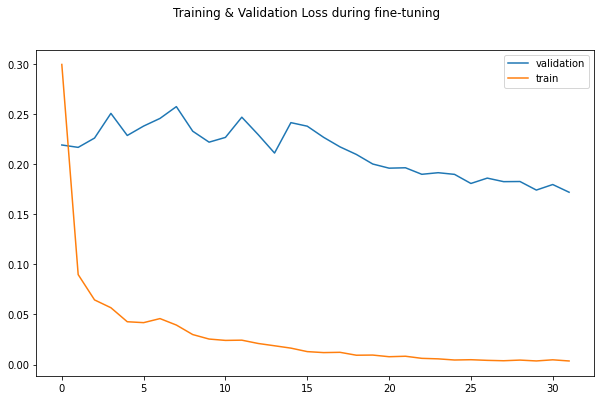

In [15]:
## lets see loss
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");